<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/ImageGeneration/CNN_Texture_Synthesis_with_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Texture synthesis with CNNs in PyTorch

## Introduction ##

This practical session explains how to implement the Texture Synthesis based on the algorithm described on [L. Gatys, A. S. Ecker, and M. Bethge. Texture synthesis using convolutional neural networks. In Advances in Neural Information Processing Systems, pages 262–270, 2015. 4](https://arxiv.org/abs/1505.07376). 

**Texture Synthesis:** 

Given an input texture image, produce an output texture image that is both visually similar and pixel-wise different from the input texture. The output image should ideally be perceived as another part of the same large piece of homogeneous material from which the input texture originated.

**References:**

This practical session is based on several resources:

*   Original code: https://github.com/leongatys/DeepTextures
*   Reimplementation: https://github.com/trsvchn/deep-textures
*   Tutorial used for some explanation: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

**Authors:**
* [Bruno Galerne](https://github.com/bgalerne)
* Lucía Bouza

## Underlying principle

Let us recall the algorithm proposed by Gatys et al.
Given an example image $u$ and a random initialization $x_0$, 
we optimize the loss function 
$$
E(x) = \sum_{\text{for selected layers } L} w_L\left\| G^L(x) - G^L(u) \right\|^2_F
$$
where $\|\cdot\|_F$ is the Frobenius norm and for an image $y$ and a layer index $L$ $G^L(y)$ denotes the Gram matrix of the VGG-19 features at layer $L$:
if $V^L(y)$ is the feature response of $y$ at layer $L$ that has spatial size $w\times h$ and $n$ channels, 
$$
G^L(y) = \frac{1}{w h}\sum_{k\in \{0,\dots,w-1\}\times\{0,\dots,h-1\}} V^L(y)_k V^L(y)_k^T \in \mathbb{R}^{n\times n}.
$$
The optimization is done using the L-BFGS algorithm.

## Exercise:


1. Go through the code and execute the algorithm.

2. We use the outputs of 5 VGG-19 layers to define $E$. Verify that the quality of the output texture decreases if fewer layers are used (e.g. only the first layer or the three first layers).

## Importing packages

Below is a list of packages needed to implement texture synthesis. PyTorch version used to run this notebook is **1.11.0+cu113** (to check the installed version, use `torch.__version__`)

* `torch` (indispensable packages for neural networks with PyTorch)
* `torch.optim` (efficient gradient descent)
* `mse_loss` (compute loss)
* `torchvision.models` (get the vgg network)
* `torchvision.transforms.functional` (transform images into tensors)
* `PIL.Image, matplotlib.pyplot` (display of images and graphics)
* `os` (interactions with the operating system)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.functional import mse_loss
import torchvision.models as models
from torchvision.transforms.functional import resize, to_tensor, to_pil_image

from PIL import Image
import matplotlib.pyplot as plt
import os

To import the solutions, execute the following cell. If you are using a Windows system, comment the `os.system` line, download the file by hand, and place it in the same folder as the notebook.

In [ ]:
#os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/ImageGeneration/Solutions/TS.py")
#from TS import *

## Loading images

In the next section we will load images. Here we'll just get, display, and save the image, without making any changes to it.


In [ ]:
texture_imgnames = ["bois.png", "briques.png", "mur.png", "tissu.png", "nuages.png","pebbles.jpg","wall1003.png"]

for fname in texture_imgnames:
    os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/Textures/"+fname)
    img = Image.open(fname)

## Set a device

Next, we need to choose which device to run the algorithm on. Running the algorithm on large images takes longer and will go much faster when running on a GPU. We can use `torch.cuda.is_available()` to detect if there is a GPU available. Next, we set the `torch.device`. The `.to(device)` method is used to move tensors or modules to a desired device, we will use it in next sections. 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
!nvidia-smi

## Data preparation

An important detail to note is that the neural network model we will use is trained on preprocessing images. We will need to apply the same preprocessing step to the image tensor before sending it into the network.

The preprocessing step consists only on subtracting the mean RGB value, computed on the training set (Imagenet), from each pixel. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. Therefore, after subtracting the mean (`[0.485, 0.456, 0.406]`), it is necessary to multiply the tensor by 255 to the values be between 0 and 255 again. 
Read the following [paper](https://arxiv.org/pdf/1409.1556.pdf) on section 2.1 to learn more details about VGG training. 

Here are some helper functions for loading, displaying and transforming into tensors.

In [ ]:
#@title
# Utilities
# Functions to manage images

MEAN = (0.485, 0.456, 0.406)

# Based on Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py
def prep_img(image: str, size=None, mean=MEAN):
    """Preprocess image.
    1) load as PIl
    2) resize
    3) convert to tensor
    5) remove alpha channel if any
    4) substract mean and multipy by 255
    """
    im = Image.open(image)
    texture = resize(im, size)
    tensor = to_tensor(texture).unsqueeze(0)
    if tensor.shape[1]==4:
        print('removing alpha chanel')
        tensor = tensor[:,:3,:,:]
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
    tensor.sub_(mean).mul_(255)
    return tensor

# Based on Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py
def denormalize(tensor: torch.Tensor, mean=MEAN):

    tensor = tensor.clone().squeeze() 
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
    tensor.mul_(1./255).add_(mean)
    return tensor

# Taras Savchyn's code
# https://github.com/trsvchn/deep-textures/blob/main/deeptextures/utils.py
def to_pil(tensor: torch.Tensor):
    """Converts tensor to PIL Image.
    Args: tensor (torch.Temsor): input tensor to be converted to PIL Image of torch.Size([C, H, W]).
    Returns: PIL Image: converted img.
    """
    img = tensor.clone().detach().cpu()
    img = denormalize(img).clip(0, 1)
    img = to_pil_image(img)
    return img


def printResults(target, opt_img, iter, loss):
    """ Displays the intermediate results of the main iteration
    """
    print('Iteration: %d, loss: %f'%(iter, loss.item()))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
    axes[0].imshow(to_pil(target.squeeze(0)))
    axes[0].set_title('Original texture')
    axes[1].imshow(to_pil(opt_img.squeeze(0)))
    axes[1].set_title('Synthesis')
    fig.tight_layout()
    plt.pause(0.05)

## Model

Now we need to define the neural network and import a pretrained model. We will use a 19-layer VGG network from PyTorch and the pretrained model used on the [paper](https://arxiv.org/abs/1505.07376). We use this particular model because it is a normalized version of the VGG network. Here, the weights are scaled such that the mean activation of each filter over training images and positions is equal to 1. The benefit of normalization is that losses based on features extracted from different layers of the network will have comparable magnitude. 
On this [github site](https://github.com/corleypc/vgg-normalize) you can find a detailed explanation of how  normalization works and an implementation to do it. Also [this thread](https://stats.stackexchange.com/questions/361723/weight-normalization-technique-used-in-image-style-transfer) can help to understand the process.  

VGG's PyTorch implementation is a module split into two sequential child modules: features (containing convolution and pooling layers) and classifier (containing fully connected layers). For the texture synthesis task, we are only interested in the layers of the features module. We won't let the parameters change: the network is already trained and used as an image transformation.


First we will need to download the pretrained model. This model is stored on Google Drive, but is the same metioned on the paper (The [official site](http://bethgelab.org/media/uploads/deeptextures/vgg_normalised.caffemodel) sometimes is down). 

In [ ]:
import gdown
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=1lLSi8BXd_9EtudRbIwxvmTQ3Ms-Qh6C8",'vgg_conv.pth')

We cannot directly load the model into the PyTorch VGG network because the keys are not the same in the pretrained model. That's why we iterate over the VGG parameters and the pretrained model dictionary, to load the weights.

In the output of the following commands, you can see the `feature` module structure. The indexes will help to select the necessary layers for the algorithm.

In [ ]:
cnn = models.vgg19(pretrained=False).features.to(device)
pretrained_dict = torch.load('vgg_conv.pth')

for param, item in zip(cnn.parameters(), pretrained_dict.keys()): 
    param.data = pretrained_dict[item].type(torch.FloatTensor).to(device)

cnn.requires_grad_(False)

According to the algorithm explained at the beginning of this notebook, we need to access the outputs of some selected intermediate layers. In order to access the outputs of the layers on the PyTorch VGG19 network, we need to register a hook on each layer we need. Hooks are functions, which can be attached to each layer and called each time the layer is used. You can register a hook before or after the forward pass, or after the backward pass. We will define a function `save_output` that will be triggered after the forward pass, for each layer of the `features` module. 

The layer outputs will be stored in a dictionary where the key is the layer index and the value is the layer output tensor.

So we need to define which layers will be part of the optimization and define weights for each one (we will use the weights when performing the texture synthesis). Using the layer indices, we select the layers to use in the algorithm. The output of the first conv layer and the outputs of the pools layers are a good selection. This is why we choose the indices 0, 4, 9, 18, 27.

In [ ]:
# Initialize outputs dic
outputs = {}

# Hook definition
def save_output(name):
    
    # The hook signature
    def hook(module, module_in, module_out):
        outputs[name] = module_out
    return hook

# Define layers
layers = [1, 6, 11, 20, 29]
# Define weights for layers
layers_weights = [1/n**2 for n in [64,128,256,512,512]]

# Register hook on each layer with index on array "layers"
for layer in layers:
    handle = cnn[layer].register_forward_hook(save_output(layer))

## Loss function

We need to define the Loss function as explained at the beginning of the notebook. We first define a function to calculate the Gram Matrix, then a loss function that computes the MSE for 2 Gram matrices. 



In [ ]:
# Computes Gram matrix for the input batch tensor.
#    Args: tnsr (torch.Tensor): input tensor of the Size([B, C, H, W]).
#    Returns:  G (torch.Tensor): output tensor of the Size([B, C, C]).
def gramm(tnsr: torch.Tensor) -> torch.Tensor: 

    b,c,h,w = tnsr.size() 
    F = tnsr.view(b, c, h*w)
    G = torch.bmm(F, F.transpose(1,2)) 
    G.div_(h*w)
    return G

# Computes MSE Loss for 2 Gram matrices 
def gram_loss(input: torch.Tensor, gramm_target: torch.Tensor, weight: float = 1.0):
  
    loss = weight * mse_loss(gramm(input), gramm_target)
    return loss


## Optimizer and initialization

In this section we choose the target texture. This image is converted into a tensor, then the activations of the layers selected for this tensor are computed (dictionary `outputs` after forward pass using target texture). We  will also compute Gram Matrix for these activations (these values doesn't change so is efficient calculate them only once).

removing alpha chanel


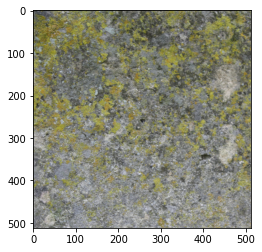

In [ ]:
######################################################
### This section allows you to change target image ###
######################################################
# Select input image: ["bois.png", "briques.png", "mur.png", "tissu.png", "nuages.png","pebbles.jpg","wall1003.png"]
input_image_name = "wall1003.png"
img_size = 512

# Prepare texture data
target = prep_img(input_image_name, img_size).to(device)
target_img = to_pil(target)
plt.imshow(target_img)

# Forward pass using target texture for get activations of selected layers (outputs). Calculate gram Matrix for those activations
cnn(target)
gramm_targets = [gramm(outputs[key]) for key in layers] 

Then, we draw the random initialization. This tensor needs to be optimized, so we set `requires_grad` to `True`.

We use L-BFGS algorithm to run gradient descent. We will create a PyTorch L-BFGS optimizer `optim.LBFGS` and pass the `synth` image to it as the tensor to optimize.

In [ ]:
# Random init for image synth
synth = torch.randn_like(target)*10
synth.requires_grad=True

# Set optimizer
optimizer = optim.LBFGS([synth])

## Running texture synthesis

We are now able to perform texture synthesis. 

At each iteration of the network, it receives an updated input and computes new losses between target activations and synth activations (activations of the layers selected for the image that it is being optimized). 

We will run the backward methods of each loss module to dynamically compute their gradients. The optimizer requires a “closure” function, which reevaluates the module and returns the loss.

0
Iteration: 0, loss: 131820.328125


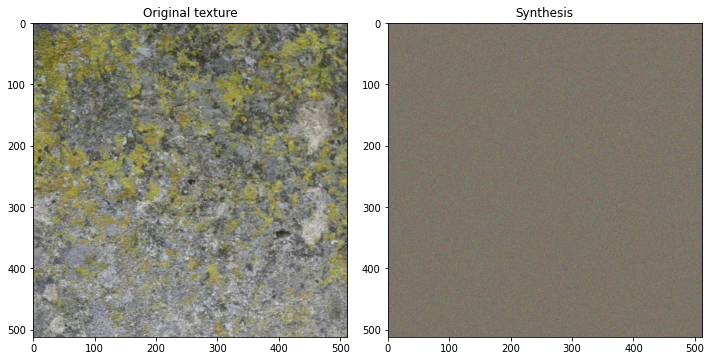

Iteration: 500, loss: 2.218308


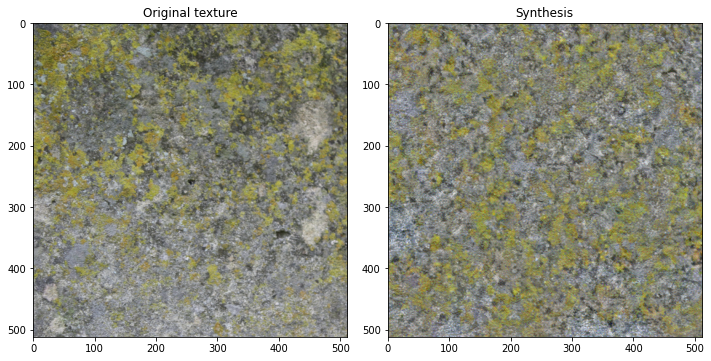

Iteration: 1000, loss: 0.812240


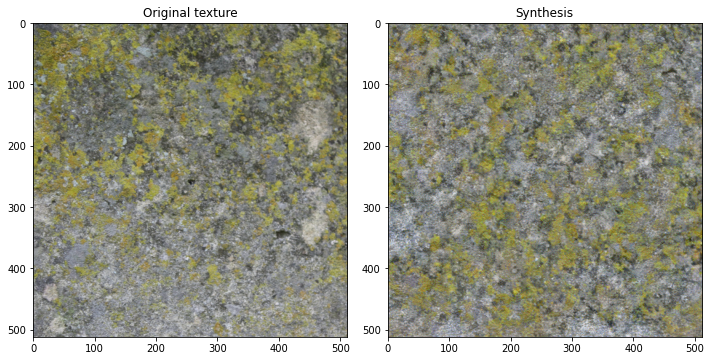

In [ ]:
def textureSynthesis (n_iters, log_every, synth, cnn, target, gramm_targets, outputs, layers, layers_weights, optimizer):
    global iter_
    iter_ = 0
    print(iter_)

    while iter_ <= n_iters:

        def closure():
            global iter_

            optimizer.zero_grad()

            # Forward pass using synth. Get activations of selected layers for image synth (outputs).
            cnn(synth)
            synth_outputs = [outputs[key] for key in layers] 
            
            # Compute loss for each activation
            losses = []
            for activations in zip(synth_outputs, gramm_targets, layers_weights):
                losses.append(gram_loss(*activations).unsqueeze(0))
            
            total_loss = torch.cat(losses).sum()
            total_loss.backward()

            # Display results: print Loss value and show images
            if iter_ % log_every == 0:
                printResults(target, synth, iter_, total_loss)

            iter_ += 1

            return total_loss

        optimizer.step(closure)

    return synth

n_iters = 1000
log_every = 500

synth = textureSynthesis (n_iters, log_every, synth, cnn, target, gramm_targets, outputs, layers, layers_weights, optimizer)

# Exercise 2:

Pick one of the following problems:

* **A: Color correction** 
  
  Observe that for some image the color is inconsistant (eg with `wall1003.png`). A solution to correct the output color distribution is to incorporate the mean color and the color covariance as a target statistics in $E$. 

  **Hint**: Considering mean color vector $m$ and covariance matices $C_h = C_h(0)$:

  $$
  m = \begin{pmatrix}
  m_r \\
  m_g \\
  m_b
  \end{pmatrix}
  = \frac{1}{MN}\sum_{t\in\Omega} h(t) \in \mathbb{R}^{3}
  $$
  $$
  C_h = \frac{1}{MN}\sum_{t\in\Omega} 
  \begin{pmatrix}
  h_r(t) - m_r \\
  h_g(t) - m_g \\
  h_b(t) - m_b
  \end{pmatrix}
  \begin{pmatrix}
  h_r(t) - m_r \\
  h_g(t) - m_g \\
  h_b(t) - m_b
  \end{pmatrix}^T
  \in\mathbb{R}^{3\times 3}.
  $$

  Then change $E$ to:
  $ E + \lambda_{mean} \| m(x) - m(u)\|^2 + \lambda_{cov} \| C(x) - C(u)\|^2. $

  Try with $\lambda_{mean}$ and $\lambda_{cov}$ between 0.1 and 10.



* **B: Spectral correction** 

  Add a term to the energy that would enforce a consistency with the original Fourier spectrum of each color channel, that is change $E$ to: 
$$
E + \lambda_{Fourier} \| |\hat{x}| - |\hat{u}|\|^2.
$$
Try with $\lambda_{Fourier}$ between 1 and 0.01 to see the differences. Experiment with different types of textures.
What is the interest of this approach?
What are the textures for which it improves or degrades the quality of the result? 



* **C: Order one statistics** 

  Replace $E$ so that the spatial average of ALL the VGG-19 layers is preserved,. Change $E$ to:
$$
  E_{mean} (x) = \sum_{\text{for all layers } L} w_L \left\| \operatorname{mean}(V^L(x)) - \operatorname{mean}(V^L(u)) \right\|^2_F
$$
  Here, consider weighting the layers with the same approach made in the notebook. The mean is computed along the spatial dimension, so for each layer the mean vector has size "number of channels within the layer". 
 Compare with the original model. What is the interest of this approach?

## Solutions

### Exercise A

We will change the loss function. We will add to the Gramm loss the "A_loss". `A_loss` computes the MSE (weighted by lambda1) between means of colors of target and synth image, as well as the MSE (weighted by lambda2) of the covariances matrices of the target and synth image. 

Run this cell to use another texture image and restart the synth image:

In [ ]:
#@title
image = "pebbles.jpg"
img_size = 256

# Prepare texture data
target = prep_img(image, img_size).to(device)

# Forward pass using target texture for get activations of selected layers (outputs). Calculate gram Matrix for those activations
cnn(target)
gramm_targets = [gramm(outputs[key]) for key in layers] 

# Random init for image synth
synth = torch.randn_like(target) * 10
synth.requires_grad=True

# Set optimizer
optimizer = optim.LBFGS([synth])

The next cell runs the new optimization function.

torch.Size([3])
torch.Size([1, 3, 3])
Iteration: 0, loss: 9799772.000000


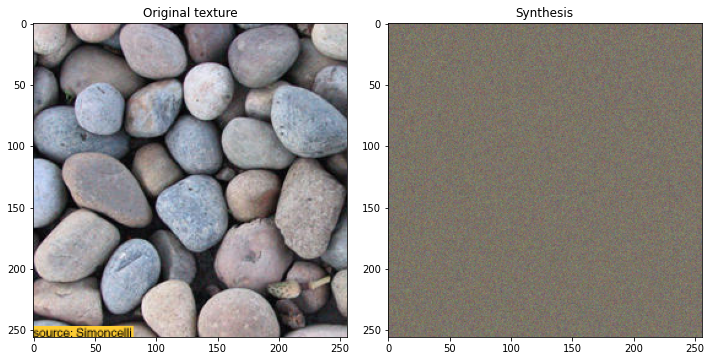

Iteration: 1000, loss: 191.843750


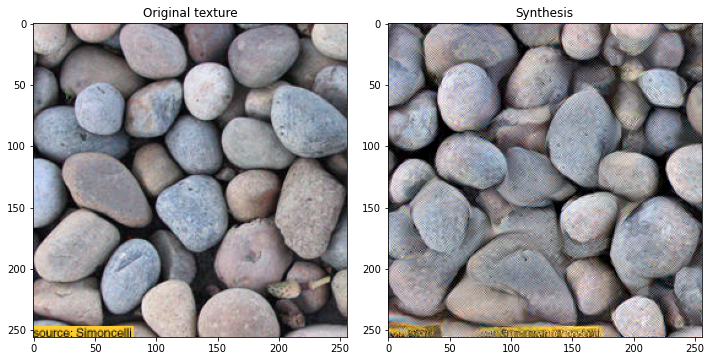

Iteration: 2000, loss: 155.111435


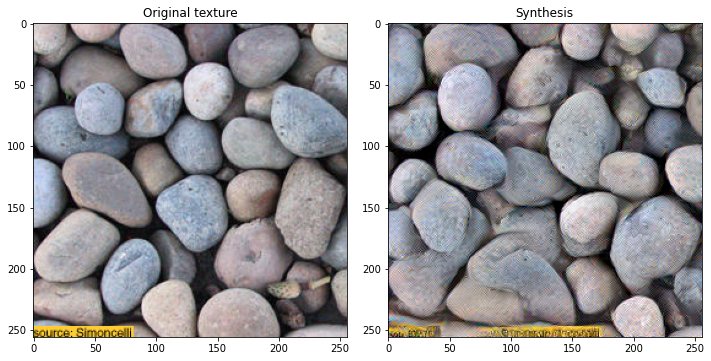

In [ ]:
n_iters = 2000
log_every = 1000

synth = textureSynthesisA (n_iters, log_every, synth, cnn, target, gramm_targets, outputs, layers, layers_weights, optimizer)

### Exercise B

We will change the loss function. We will add to the Gramm loss the "B_loss". `B_loss` computes the MSE (weighted by lambda3) between Fourier absolute values for the target and synth image. By adding this statistic to the loss function, we are taking into account periodic signals on images. 

Run this cell to use another texture image and restart the synth image:

In [ ]:
#@title
image = "briques.png"
img_size = 256

# Prepare texture data
target = prep_img(image, img_size).to(device)
target_img = to_pil(target)

# Forward pass using target texture for get activations of selected layers (outputs). Calculate gram Matrix for those activations
cnn(target)
gramm_targets = [gramm(outputs[key]) for key in layers] 

# Random init for image synth
synth = torch.randn_like(target) * 10
synth.requires_grad=True

# Set optimizer
optimizer = optim.LBFGS([synth])

The next cell runs the new optimization function.

Iteration: 0, loss: 8536836.000000


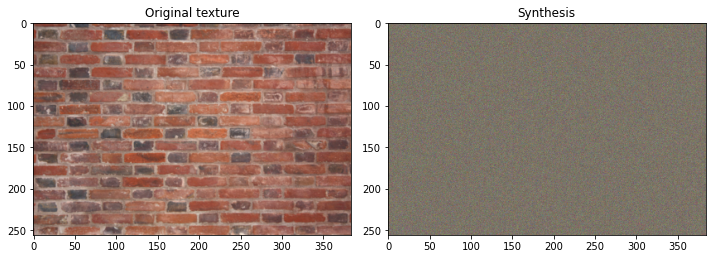

Iteration: 1000, loss: 20.390854


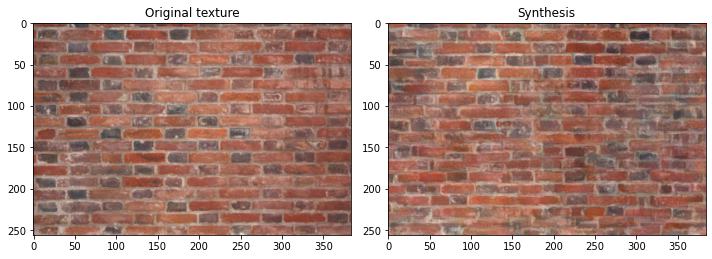

Iteration: 2000, loss: 13.380077


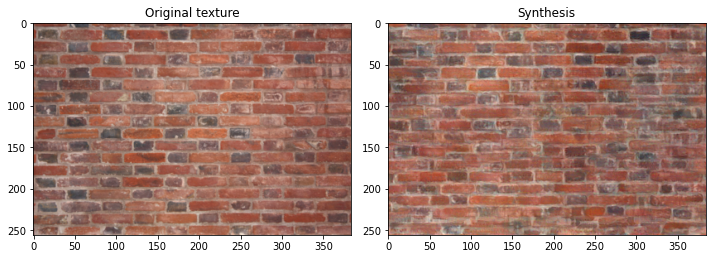

Iteration: 3000, loss: 11.148575


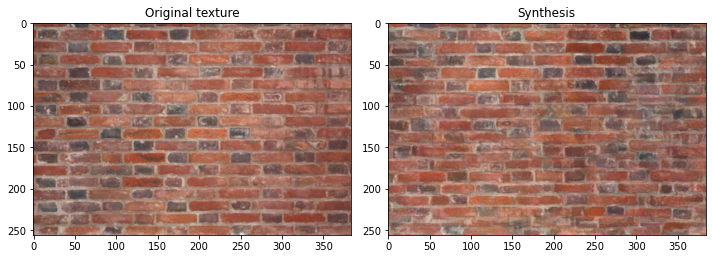

In [ ]:
n_iters = 3000
log_every = 1000

synth = textureSynthesisB (n_iters, log_every, synth, cnn, target, gramm_targets, outputs, layers, layers_weights, optimizer)

For textures with patterns, when lambda increases (example lambda = 1), the synthesis captures the patterns, but has difficulty capturing colors, for example. For smaller lambdas (example lambda = 0.01), colors are taken into account, but the model has a harder time capturing patterns. 

### Exercise C

With this approach we don't need to calculate Gram Matrices, so amount of parameters decreases. 

Run this cell to use another texture image and restart the synth image:

In [ ]:
#@title
image = "pebbles.jpg"
img_size = 256

# Prepare texture data
target = prep_img(image, img_size).to(device)
target_img = to_pil(target)

# Random init for image synth
synth = torch.randn_like(target) * 10
synth.requires_grad=True

# Set optimizer
optimizer = optim.LBFGS([synth])

We will need to register the hook on all layers because we need the outputs of all layers.

In [ ]:
# Register hook on each layer with index on array "layers"
for layer in range(37):
    handle = cnn[layer].register_forward_hook(save_output(layer))

#Get target activations of all layers
cnn(target)
target_outputs = [outputs[key] for key in range(37)]

The next cell runs the new optimization function.

Iteration: 0, loss: 54497.648438


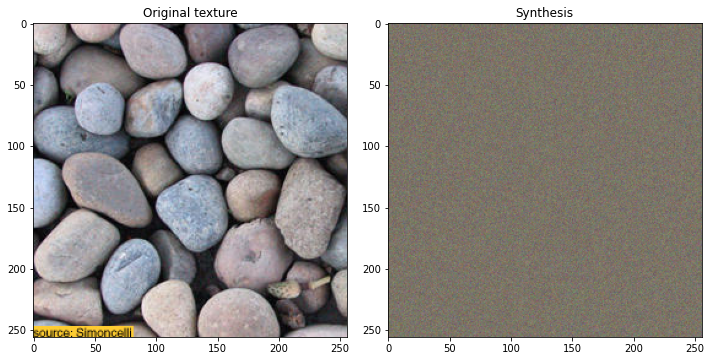

Iteration: 1000, loss: 0.250517


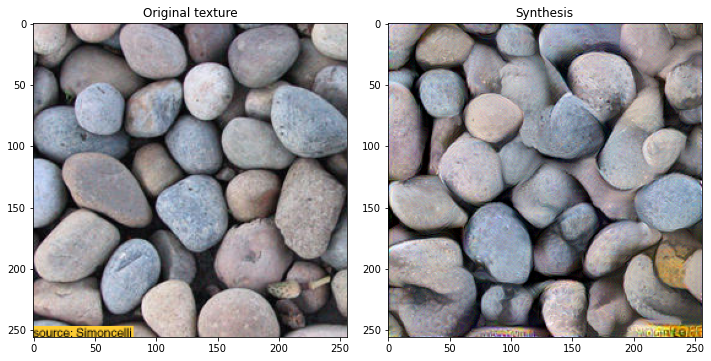

Iteration: 2000, loss: 0.135229


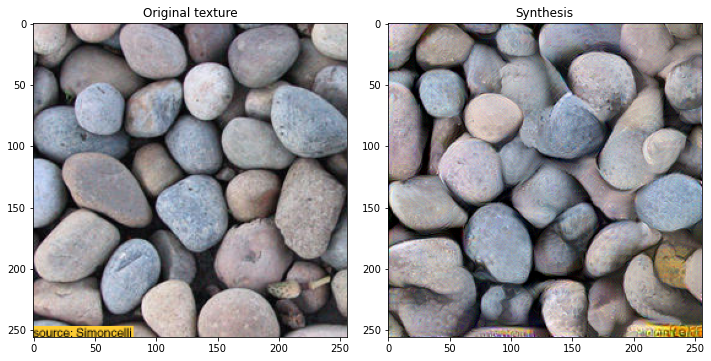

Iteration: 3000, loss: 0.103111


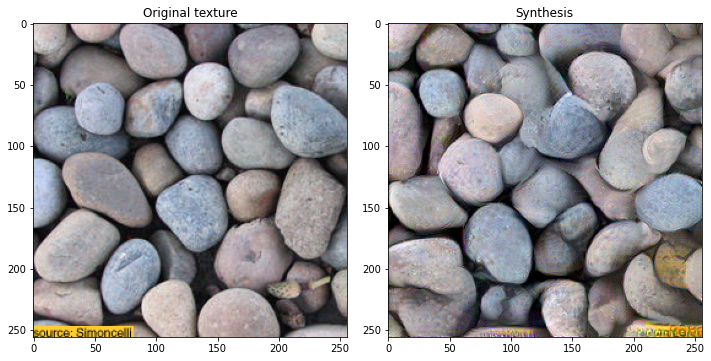

In [ ]:
n_iters = 3000
log_every = 1000

synth = textureSynthesisC (n_iters, log_every, synth, cnn, target, target_outputs, outputs, optimizer)